Missing rows before: 36
Training Data Size: 21894
Test Data Size: 15325

Processing 1 hour(s) after...
Fitting 3 folds for each of 36 candidates, totalling 108 fits
Fitting 3 folds for each of 36 candidates, totalling 108 fits
Fitting 3 folds for each of 36 candidates, totalling 108 fits
Fitting 3 folds for each of 36 candidates, totalling 108 fits
Fitting 3 folds for each of 36 candidates, totalling 108 fits
Best parameters for 1 hour(s) after: {'classifier__n_estimators': 100, 'classifier__max_depth': 10, 'classifier__min_samples_split': 5, 'classifier__min_samples_leaf': 1}
Model saved for 1 hour(s) after
1 hours after: Test F1 Score: 0.96, Test ROC-AUC: 0.98

Processing 2 hour(s) after...
Fitting 3 folds for each of 36 candidates, totalling 108 fits
Fitting 3 folds for each of 36 candidates, totalling 108 fits
Fitting 3 folds for each of 36 candidates, totalling 108 fits
Fitting 3 folds for each of 36 candidates, totalling 108 fits
Fitting 3 folds for each of 36 candidates, totalli

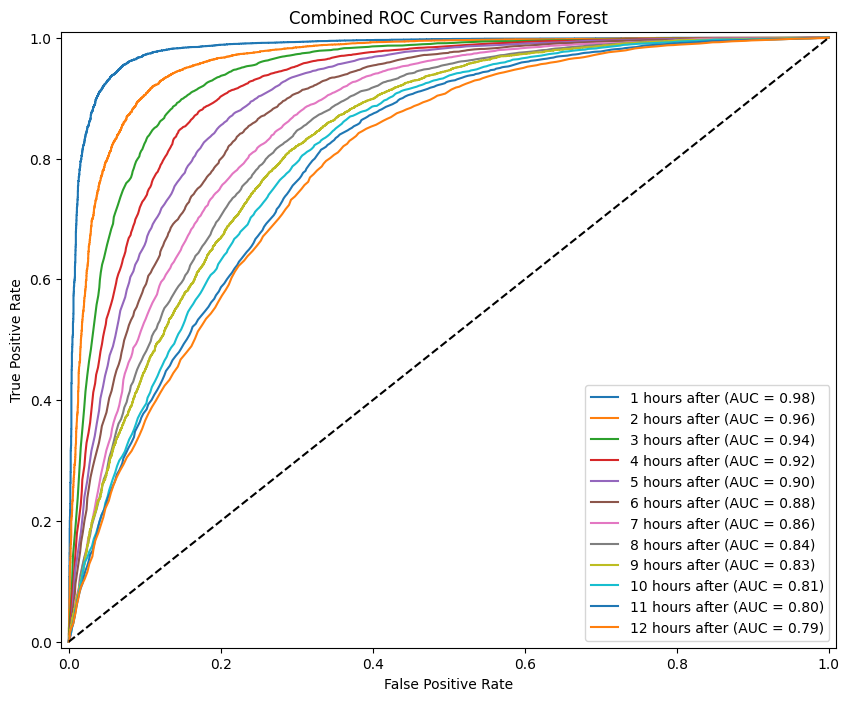

Averaged F1 Score: 0.89
Averaged ROC-AUC: 0.91
Predicted values have been saved to rf_pred.csv
Best parameters for each hour have been saved to rf_params.txt
ROC curves have been saved as rf.png


In [ ]:
"""
Random Forest Classifier with Nested Cross-Validation
"""
#%% Import data
import pandas as pd

file_path = '../data/data.csv'
data = pd.read_csv(file_path, index_col=0)

data['pm2.5'] = data['pm2.5'].interpolate()

for i in range(1, 13):
    data[f'pm2.5_{i}_hour_after'] = data['pm2.5'].shift(-i)

data = pd.get_dummies(data, columns=['cbwd'])

missing_rows_before = data.isna().any(axis=1).sum()
print(f"Missing rows before: {missing_rows_before}")

data.dropna(subset=['pm2.5'] + [f'pm2.5_{i}_hour_after' for i in range(1, 13)], inplace=True)

split_index_train = int(len(data) * 0.5)
split_index_test = int(len(data) * 0.85)

data_train = data.iloc[:split_index_train]
data_test = data.iloc[split_index_train:split_index_test]

print(f"Training Data Size: {data_train.shape[0]}")
print(f"Test Data Size: {data_test.shape[0]}")

from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedKFold, GridSearchCV, train_test_split
from sklearn.metrics import roc_auc_score, f1_score, roc_curve
import matplotlib.pyplot as plt
import numpy as np
from collections import Counter
import joblib

X_train = data_train.drop(columns=[f'pm2.5_{j}_hour_after' for j in range(1, 13)] + ['year'])
X_test = data_test.drop(columns=[f'pm2.5_{j}_hour_after' for j in range(1, 13)] + ['year'])

numerical_columns = X_train.select_dtypes(include=['float64', 'int64']).columns

preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_columns)
    ],
    remainder='passthrough'
)

f1_scores = []
roc_aucs = []
best_params = []

num_hours = 12

param_grid = {
    'classifier__n_estimators': [100, 200, 300],
    'classifier__max_depth': [None, 10, 20],
    'classifier__min_samples_split': [2, 5],
    'classifier__min_samples_leaf': [1, 2]
}

plt.figure(figsize=(10, 8))
predictions = {}

for i in range(1, num_hours + 1):
    print(f"\nProcessing {i} hour(s) after...")

    y_train = (data_train[f'pm2.5_{i}_hour_after'] >= 50).astype(int)
    y_test = (data_test[f'pm2.5_{i}_hour_after'] >= 50).astype(int)

    X_train_split, X_valid_split, y_train_split, y_valid_split = train_test_split(
        X_train, y_train, test_size=0.2, random_state=1, stratify=y_train
    )

    outer_cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=1)
    inner_cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=1)

    pipeline = Pipeline([
        ('preprocessor', preprocessor),
        ('classifier', RandomForestClassifier(random_state=1))
    ])

    grid_search = GridSearchCV(
        estimator=pipeline,
        param_grid=param_grid,
        cv=inner_cv,
        scoring='f1',
        n_jobs=-1,
        verbose=2
    )

    nested_f1 = []
    nested_roc_auc = []
    current_best_params = []

    for train_idx, valid_idx in outer_cv.split(X_train_split, y_train_split):
        X_outer_train, X_outer_valid = X_train_split.iloc[train_idx], X_train_split.iloc[valid_idx]
        y_outer_train, y_outer_valid = y_train_split.iloc[train_idx], y_train_split.iloc[valid_idx]

        grid_search.fit(X_outer_train, y_outer_train)

        best_model = grid_search.best_estimator_
        current_best_params.append(grid_search.best_params_)

        y_pred_outer = best_model.predict(X_outer_valid)
        y_prob_outer = best_model.predict_proba(X_outer_valid)[:, 1]

        f1 = f1_score(y_outer_valid, y_pred_outer)
        roc_auc = roc_auc_score(y_outer_valid, y_prob_outer)

        nested_f1.append(f1)
        nested_roc_auc.append(roc_auc)

    avg_f1 = np.mean(nested_f1)
    avg_roc_auc = np.mean(nested_roc_auc)
    f1_scores.append(avg_f1)
    roc_aucs.append(avg_roc_auc)

    best_params_counter = {}
    for param in param_grid.keys():
        param_values = [params[param] for params in current_best_params]
        most_common = Counter(param_values).most_common(1)[0][0]
        best_params_counter[param] = most_common

    best_params.append(best_params_counter)
    print(f"Best parameters for {i} hour(s) after: {best_params_counter}")

    pipeline.set_params(**best_params_counter)
    pipeline.fit(X_train_split, y_train_split)

    joblib.dump(pipeline.named_steps['classifier'], f'../outputs/rf_hour_{i}.joblib')
    print(f'Model saved for {i} hour(s) after')

    y_pred_test = pipeline.predict(X_test)
    y_prob_test = pipeline.predict_proba(X_test)[:, 1]

    predictions[f'Hour_{i}_Predictions'] = y_pred_test

    f1_test = f1_score(y_test, y_pred_test)
    roc_auc_test = roc_auc_score(y_test, y_prob_test)

    f1_scores.append(f1_test)
    roc_aucs.append(roc_auc_test)

    print(f"{i} hours after: Test F1 Score: {f1_test:.2f}, Test ROC-AUC: {roc_auc_test:.2f}")

    fpr_test, tpr_test, _ = roc_curve(y_test, y_prob_test)
    plt.plot(fpr_test, tpr_test, label=f'{i} hours after (AUC = {roc_auc_test:.2f})')

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([-0.01, 1.01])
plt.ylim([-0.01, 1.01])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Combined ROC Curves Random Forest')
plt.legend(loc="lower right")
plt.savefig('../outputs/rf.png')
plt.show()

print(f"Averaged F1 Score: {np.mean(f1_scores):.2f}")
print(f"Averaged ROC-AUC: {np.mean(roc_aucs):.2f}")

prediction_df = pd.DataFrame(predictions)
prediction_df.to_csv('../outputs/rf_pred.csv', index=False)
print("Predicted values have been saved to rf_pred.csv")

with open('../outputs/rf_params.txt', 'w') as f:
    for idx, params in enumerate(best_params):
        f.write(f"Hour {idx + 1} Best Parameters: {params}\n")

print("Best parameters for each hour have been saved to rf_params.txt")
print("ROC curves have been saved as rf.png")